# TinyNeRF: Neural Radiance Fields for 3D Cube Reconstruction

This notebook implements a simplified Neural Radiance Field (NeRF) to learn 3D representations from 2D images of a synthetic cube. We'll:

1. **Generate synthetic cube data** from multiple viewpoints
2. **Build a simple NeRF model** using MLPs
3. **Train the model** to reconstruct novel views
4. **Evaluate results** by comparing with ground truth

## What is NeRF?

NeRF represents scenes as continuous 5D functions that map 3D coordinates (x,y,z) and viewing directions (θ,φ) to density and color values. By training on multiple 2D views, it learns to synthesize photorealistic novel viewpoints.

In [1]:
# Import required libraries
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import json
import cv2
from typing import Tuple
import io
from PIL import Image
from IPython.display import clear_output

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create directories for data storage
os.makedirs("cube_data", exist_ok=True)
os.makedirs("cube_data/images", exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## 1. Synthetic Cube Dataset Generation

We'll create a synthetic dataset by rendering a 3D cube from multiple camera viewpoints. Each image comes with:
- Camera pose (position and orientation)
- Intrinsic parameters (focal length)
- 2D RGB image

This simulates the typical NeRF input: multiple photos of a scene taken from different angles.

In [2]:
def generate_cube_dataset(output_dir="cube_data", image_size=(200, 200), num_views=20):
    """Generate synthetic cube views with camera poses"""

    # Define cube vertices (unit cube centered at origin)
    vertices = np.array([
        [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],  # bottom face
        [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]   # top face
    ]) - 0.5  # Center the cube

    # Define cube faces for rendering
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],  # bottom
        [vertices[4], vertices[5], vertices[6], vertices[7]],  # top
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # front
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # back
        [vertices[1], vertices[2], vertices[6], vertices[5]],  # right
        [vertices[4], vertices[7], vertices[3], vertices[0]]   # left
    ]

    # Camera parameters
    azimuths = np.linspace(0, 360, num_views, endpoint=False)  # Circular camera path
    elevation = 30  # Fixed elevation angle
    camera_distance = 3.0  # Distance from origin
    focal_length = 200.0  # Focal length for synthetic camera

    # Storage for poses and images
    poses_data = []
    images = []

    print(f"Generating {num_views} cube views...")

    for i, azim in enumerate(azimuths):
        # Create 3D plot of cube
        fig = plt.figure(figsize=(4, 4), dpi=50)
        ax = fig.add_subplot(111, projection='3d')

        # Render cube with green faces
        cube = Poly3DCollection(faces, facecolors='green', alpha=0.9,
                              edgecolors='darkgreen', linewidths=1.5, shade=True)
        ax.add_collection3d(cube)

        # Set camera viewpoint
        ax.view_init(elev=elevation, azim=azim)
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])

        # Clean up plot appearance
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_alpha(0)
        ax.yaxis.pane.set_alpha(0)
        ax.zaxis.pane.set_alpha(0)
        ax.set_facecolor('white')
        fig.patch.set_facecolor('white')

        # Save to buffer and convert to image
        plt.tight_layout(pad=0)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0,
                   facecolor='white', edgecolor='none', dpi=50)
        buf.seek(0)

        img = Image.open(buf).resize(image_size, Image.Resampling.LANCZOS)
        img_array = np.array(img)[:, :, :3] / 255.0  # Convert to RGB and normalize
        images.append(img_array)

        # Save individual image
        filename = f"frame_{i:03d}.png"
        img.save(os.path.join(output_dir, "images", filename))
        plt.close(fig)

        # Calculate camera pose matrix (camera-to-world transformation)
        azim_rad = np.radians(azim)
        elev_rad = np.radians(elevation)

        # Camera position in world coordinates
        x = camera_distance * np.cos(elev_rad) * np.cos(azim_rad)
        y = camera_distance * np.cos(elev_rad) * np.sin(azim_rad)
        z = camera_distance * np.sin(elev_rad)
        camera_pos = np.array([x, y, z])

        # Build camera coordinate frame
        forward = -camera_pos / np.linalg.norm(camera_pos)  # Camera looks at origin
        world_up = np.array([0, 0, 1])
        right = np.cross(world_up, forward)
        right = right / np.linalg.norm(right)
        up = np.cross(forward, right)

        # Camera-to-world transformation matrix
        c2w = np.eye(4)
        c2w[:3, 0] = right
        c2w[:3, 1] = up
        c2w[:3, 2] = -forward  # OpenGL convention
        c2w[:3, 3] = camera_pos

        poses_data.append(c2w)

    images = np.array(images, dtype=np.float32)
    poses = np.array(poses_data, dtype=np.float32)

    # Save dataset
    np.savez(os.path.join(output_dir, "cube_data.npz"),
             images=images, poses=poses, focal=focal_length)

    return images, poses, focal_length

# Generate the dataset
images, poses, focal_length = generate_cube_dataset(num_views=20)
print(f"Dataset generated: {images.shape[0]} images of size {images.shape[1:3]}")
print(f"Focal length: {focal_length}")

Generating 20 cube views...
Dataset generated: 20 images of size (200, 200)
Focal length: 200.0


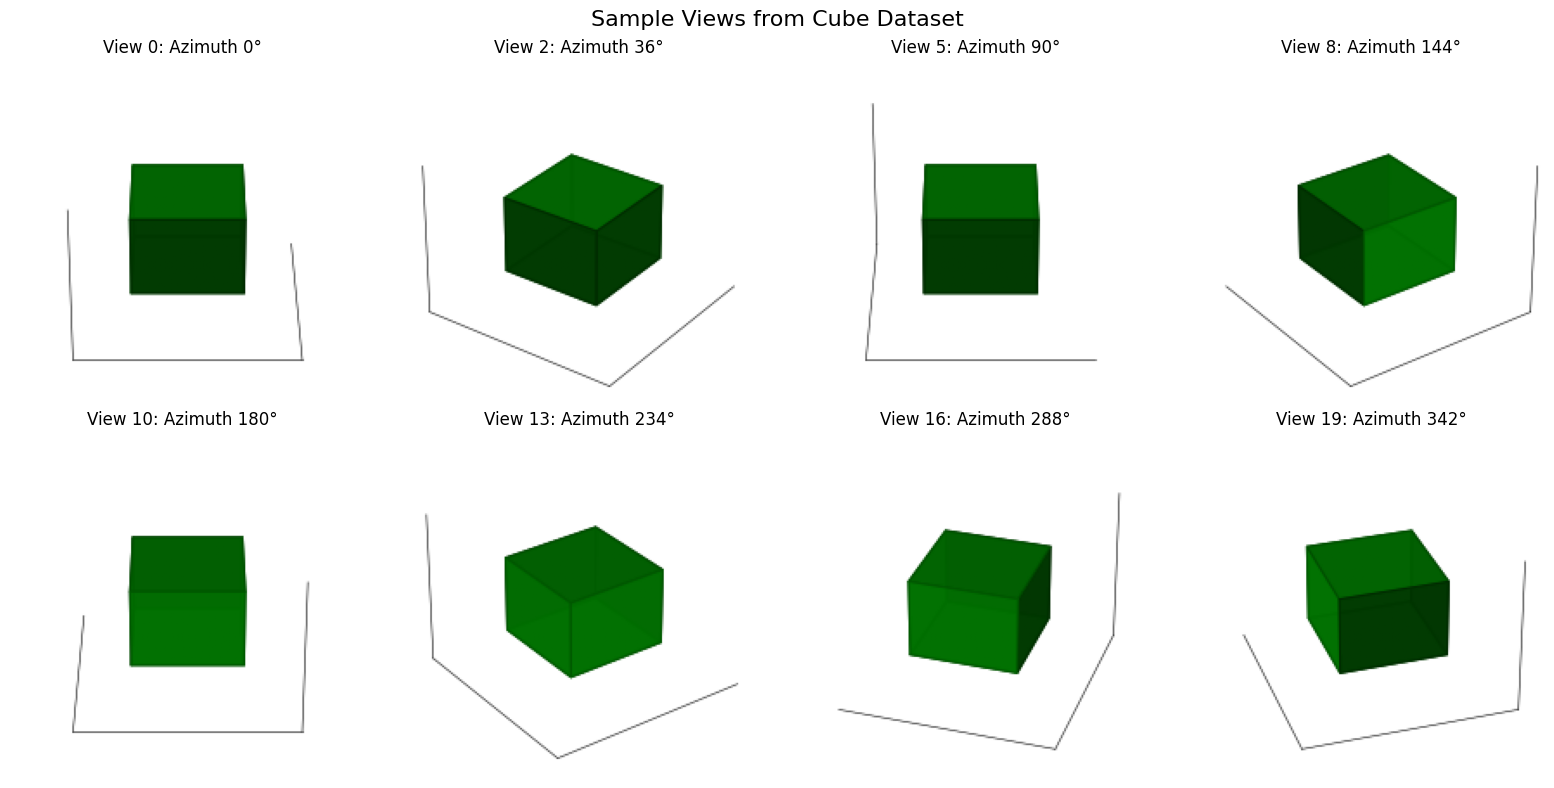

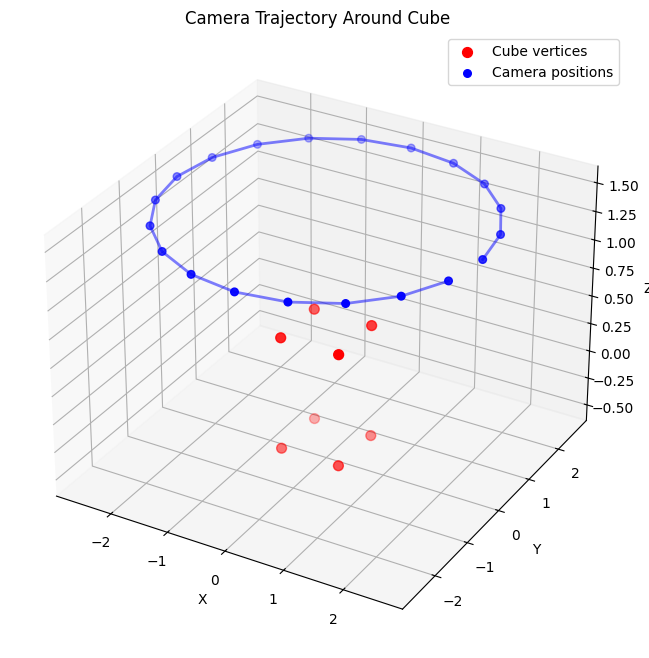

In [3]:
# Visualize the generated dataset
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Show 8 sample views
sample_indices = np.linspace(0, len(images)-1, 8, dtype=int)
for i, idx in enumerate(sample_indices):
    axes[i].imshow(images[idx])

    # Calculate azimuth for title
    x_pos, y_pos = poses[idx][0, 3], poses[idx][1, 3]
    azim = np.degrees(np.arctan2(y_pos, x_pos))
    if azim < 0:
        azim += 360

    axes[i].set_title(f"View {idx}: Azimuth {azim:.0f}°")
    axes[i].axis('off')

plt.suptitle("Sample Views from Cube Dataset", fontsize=16)
plt.tight_layout()
plt.show()

# Visualize camera positions
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot cube vertices
cube_vertices = np.array([
    [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
    [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]
]) - 0.5

ax.scatter(cube_vertices[:, 0], cube_vertices[:, 1], cube_vertices[:, 2],
          c='red', s=50, label='Cube vertices')

# Plot camera positions
camera_positions = poses[:, :3, 3]
ax.scatter(camera_positions[:, 0], camera_positions[:, 1], camera_positions[:, 2],
          c='blue', s=30, label='Camera positions')

# Connect cameras to show circular path
ax.plot(camera_positions[:, 0], camera_positions[:, 1], camera_positions[:, 2],
        'b-', alpha=0.5, linewidth=2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.set_title('Camera Trajectory Around Cube')
plt.show()

## 2. NeRF Utility Functions

Before defining the model, we need several utility functions:
- **Ray generation**: Convert 2D pixels to 3D rays
- **Sampling**: Sample points along rays for volume rendering
- **Volume rendering**: Integrate density and color along rays
- **Positional encoding**: Help the network represent high-frequency details

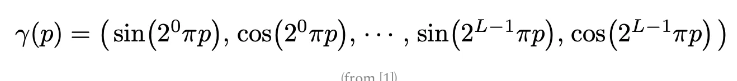

In [4]:
# Utility functions for NeRF

def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """Create meshgrid with 'xy' indexing"""
    ii, jj = torch.meshgrid(tensor1, tensor2, indexing='xy')
    return ii, jj

def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    """Exclusive cumulative product for computing transmittance"""
    cumprod = torch.cumprod(tensor, -1)
    cumprod = torch.roll(cumprod, 1, -1)
    cumprod[..., 0] = 1.
    return cumprod

def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
    """Generate ray origins and directions for all pixels in an image"""
    # Create pixel coordinates
    ii, jj = meshgrid_xy(
        torch.arange(width).to(tform_cam2world),
        torch.arange(height).to(tform_cam2world)
    )

    # Convert to normalized device coordinates
    directions = torch.stack([
        (ii - width * .5) / focal_length,
        -(jj - height * .5) / focal_length,
        -torch.ones_like(ii)
    ], dim=-1)

    # Transform directions to world coordinates
    ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
    ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)

    return ray_origins, ray_directions

def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: bool = True
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Sample 3D points along rays"""
    # Create depth values
    t_vals = torch.linspace(0., 1., num_samples).to(ray_origins)
    depth_values = near_thresh * (1. - t_vals) + far_thresh * t_vals

    # Add stratified sampling noise
    if randomize:
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = torch.rand(shape).to(ray_origins)
        bin_size = (far_thresh - near_thresh) / num_samples
        depth_values = depth_values.unsqueeze(0).unsqueeze(0).expand(shape)
        depth_values = depth_values + (noise - 0.5) * bin_size
    else:
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        depth_values = depth_values.unsqueeze(0).unsqueeze(0).expand(shape)

    # Compute 3D query points
    query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]

    return query_points, depth_values

def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Volume rendering equation implementation"""
    # Extract density and RGB from radiance field
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3])  # Density
    rgb = torch.sigmoid(radiance_field[..., :3])  # Color

    # Compute distances between adjacent samples
    one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
    dists = torch.cat((
        depth_values[..., 1:] - depth_values[..., :-1],
        one_e_10.expand(depth_values[..., :1].shape)
    ), dim=-1)

    # Volume rendering
    alpha = 1. - torch.exp(-sigma_a * dists)  # Opacity
    weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)  # Transmittance

    # Composite RGB and depth
    rgb_map = (weights[..., None] * rgb).sum(dim=-2)
    depth_map = (weights * depth_values).sum(dim=-1)
    acc_map = weights.sum(-1)

    # Add white background
    rgb_map = rgb_map + (1.0 - acc_map[..., None])
    rgb_map = torch.clamp(rgb_map, 0.0, 1.0)

    return rgb_map, depth_map, acc_map

def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
    """Apply positional encoding to help network represent high frequencies"""
    encoding = [tensor] if include_input else []

    # Create frequency bands
    frequency_bands = (
        2.0 ** torch.linspace(0.0, num_encoding_functions - 1, num_encoding_functions)
        if log_sampling
        else torch.linspace(2.0 ** 0.0, 2.0 ** (num_encoding_functions - 1), num_encoding_functions)
    ).to(tensor.device)

    # Apply sinusoidal encoding
    for freq in frequency_bands:
        for func in [torch.sin, torch.cos]:
            encoding.append(func(tensor * freq))

    return torch.cat(encoding, dim=-1) if len(encoding) > 1 else encoding[0]

def get_minibatches(inputs: torch.Tensor, chunksize: int = 1024 * 8):
    """Split inputs into smaller batches for memory efficiency"""
    return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

print("NeRF utility functions defined successfully!")

NeRF utility functions defined successfully!


## 3. NeRF Model Architecture

Our NeRF model is a simple Multi-Layer Perceptron (MLP) that:
- Takes 3D coordinates (x, y, z) as input
- Applies positional encoding to capture fine details
- Outputs density (σ) and RGB color values

The model learns to map any 3D point in space to its density and color, effectively encoding the entire 3D scene.

In [5]:
class TinyNeRFModel(torch.nn.Module):
    """Simple NeRF model with 3 fully connected layers"""

    def __init__(self, filter_size=128, num_encoding_functions=6):
        super(TinyNeRFModel, self).__init__()

        # Calculate input size: 3D coordinates + positional encoding
        # Each coordinate gets encoded as: [coord, sin(2^0*coord), cos(2^0*coord), sin(2^1*coord), ...]
        input_size = 3 + 3 * 2 * num_encoding_functions

        # Simple 3-layer MLP
        self.layer1 = torch.nn.Linear(input_size, filter_size)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        self.layer3 = torch.nn.Linear(filter_size, 4)  # Output: RGB + density

        self.relu = torch.nn.functional.relu

        print(f"TinyNeRF Model:")
        print(f"  Input size: {input_size} (3D coords + {3 * 2 * num_encoding_functions} positional encoding)")
        print(f"  Hidden size: {filter_size}")
        print(f"  Output size: 4 (RGB + density)")
        print(f"  Total parameters: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, x):
        """Forward pass through the network"""
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return self.layer3(x)

# Initialize the model
num_encoding_functions = 6
model = TinyNeRFModel(filter_size=128, num_encoding_functions=num_encoding_functions).to(device)

# Display model architecture
print("\nModel Architecture:")
for name, module in model.named_children():
    print(f"  {name}: {module}")

TinyNeRF Model:
  Input size: 39 (3D coords + 36 positional encoding)
  Hidden size: 128
  Output size: 4 (RGB + density)
  Total parameters: 22,148

Model Architecture:
  layer1: Linear(in_features=39, out_features=128, bias=True)
  layer2: Linear(in_features=128, out_features=128, bias=True)
  layer3: Linear(in_features=128, out_features=4, bias=True)


In [6]:
# Define the core NeRF rendering function
def run_nerf_iteration(height, width, focal_length, pose, near_thresh, far_thresh,
                      model, encode, num_samples):
    """Run one iteration of NeRF: render an image from a given pose"""

    # Step 1: Generate rays for all pixels
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, pose)

    # Step 2: Sample points along each ray
    query_points, depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, num_samples
    )

    # Step 3: Query the NeRF model at sampled points
    flattened_query_points = query_points.reshape((-1, 3))
    encoded_points = encode(flattened_query_points)

    # Process in batches to avoid memory issues
    batches = get_minibatches(encoded_points)
    predictions = [model(batch) for batch in batches]
    radiance_field = torch.cat(predictions, dim=0).reshape(list(query_points.shape[:-1]) + [4])

    # Step 4: Volume render to get final RGB image
    rgb_predicted, depth_map, acc_map = render_volume_density(radiance_field, ray_origins, depth_values)

    return rgb_predicted

print("NeRF rendering function defined!")

NeRF rendering function defined!


## 4. Training Loop with Visualization

Now we'll train the NeRF model by:
1. Randomly selecting a training view
2. Rendering that view using our current model
3. Comparing with the ground truth image
4. Backpropagating the error to update model weights

We'll visualize progress every few iterations to see how the model learns.

In [7]:
# Training parameters
near_thresh = 2.0  # Near clipping plane
far_thresh = 4.0   # Far clipping plane
depth_samples_per_ray = 64  # Number of samples along each ray
num_iters = 2000   # Total training iterations
lr = 5e-3          # Learning rate
display_every = 200  # How often to show progress

# Convert data to tensors
images_torch = torch.from_numpy(images[..., :3]).to(device)
poses_torch = torch.from_numpy(poses).to(device)
focal_tensor = torch.tensor(focal_length).to(device)
height, width = images_torch.shape[1:3]

# Setup training
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)

# Training tracking
psnrs = []
losses = []

print(f"Starting training for {num_iters} iterations...")
print(f"Dataset: {len(images_torch)} images of size {height}x{width}")
print(f"Samples per ray: {depth_samples_per_ray}")
print(f"Learning rate: {lr}")
print("-" * 50)

Starting training for 2000 iterations...
Dataset: 20 images of size 200x200
Samples per ray: 64
Learning rate: 0.005
--------------------------------------------------


Iteration 1999/2000: Loss = 0.010324, PSNR = 19.86 dB


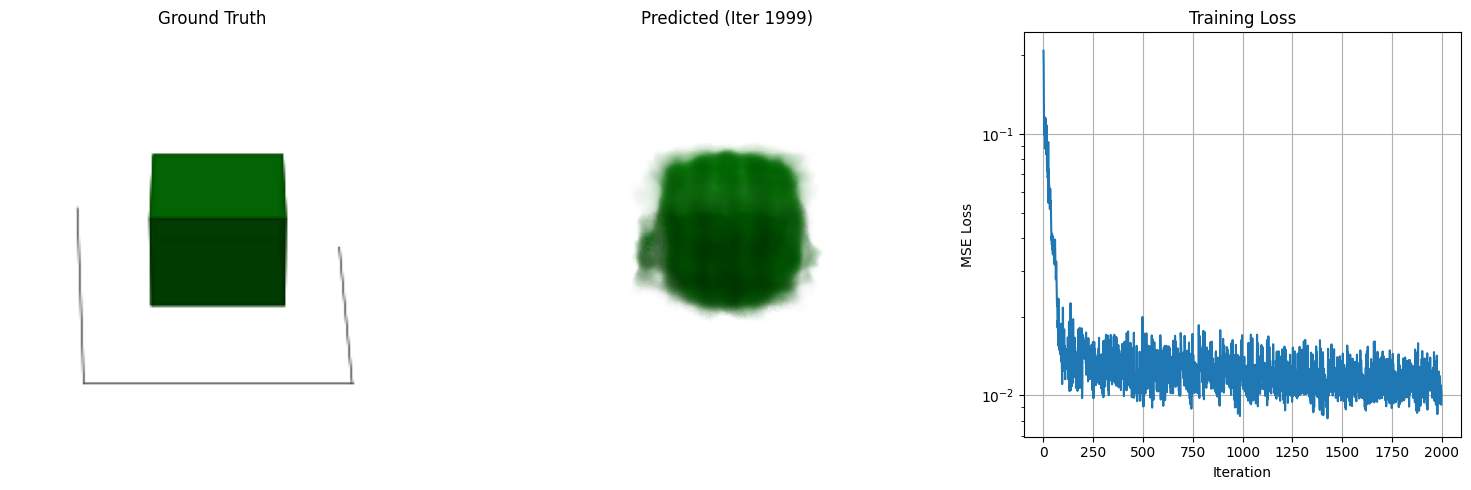


Training completed!


In [8]:
# Training loop with visualization
for i in range(num_iters):
    # Randomly select a training image
    target_img_idx = np.random.randint(images_torch.shape[0])
    target_img = images_torch[target_img_idx]
    target_pose = poses_torch[target_img_idx]

    # Render the image using current model
    rgb_predicted = run_nerf_iteration(
        height, width, focal_tensor, target_pose,
        near_thresh, far_thresh, model, encode,
        depth_samples_per_ray
    )

    # Compute loss and update model
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Record metrics
    losses.append(loss.item())

    # Display progress
    if i % display_every == 0 or i == num_iters - 1:
        psnr = -10. * torch.log10(loss)
        psnrs.append(psnr.item())

        # Clear previous output for cleaner display
        if i > 0:
            clear_output(wait=True)

        print(f"Iteration {i:4d}/{num_iters}: Loss = {loss.item():.6f}, PSNR = {psnr.item():.2f} dB")

        # Generate test prediction (always use first image for consistency)
        with torch.no_grad():
            test_prediction = run_nerf_iteration(
                height, width, focal_tensor, poses_torch[0],
                near_thresh, far_thresh, model, encode,
                depth_samples_per_ray
            )

        # Visualize current progress
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Ground truth
        axes[0].imshow(np.clip(images_torch[0].cpu().numpy(), 0, 1))
        axes[0].set_title("Ground Truth")
        axes[0].axis('off')

        # Current prediction
        axes[1].imshow(np.clip(test_prediction.detach().cpu().numpy(), 0, 1))
        axes[1].set_title(f"Predicted (Iter {i})")
        axes[1].axis('off')

        # Training loss curve
        axes[2].plot(losses)
        axes[2].set_xlabel("Iteration")
        axes[2].set_ylabel("MSE Loss")
        axes[2].set_title("Training Loss")
        axes[2].grid(True)
        axes[2].set_yscale('log')

        plt.tight_layout()
        plt.show()

print("\nTraining completed!")

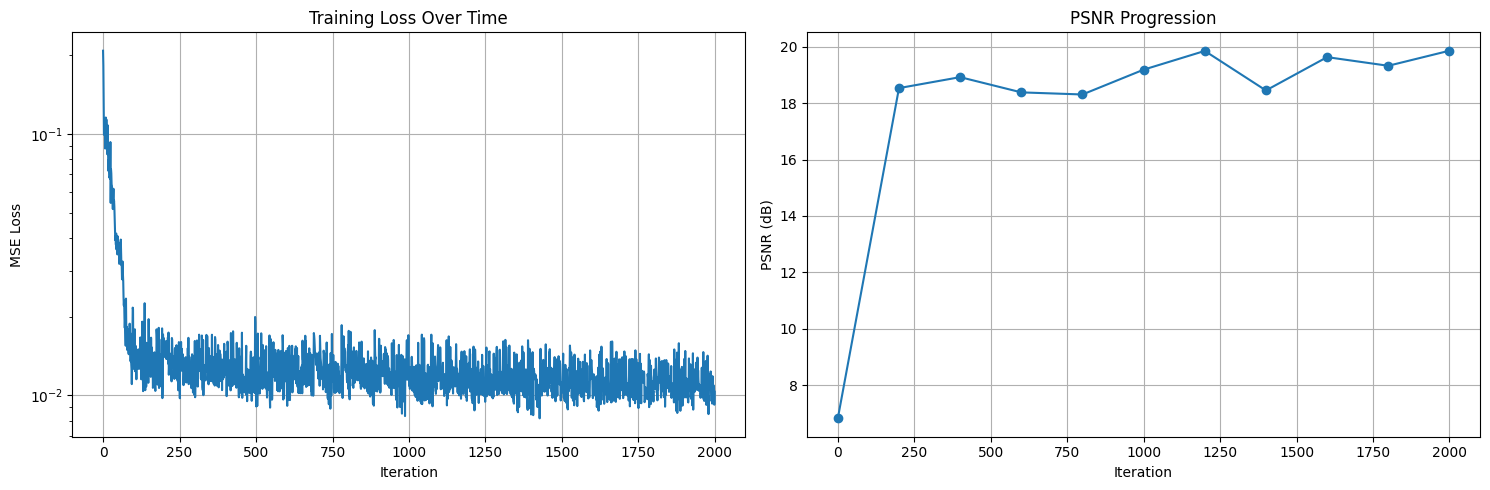

Final Training Loss: 0.010324
Final PSNR: 19.86 dB


In [9]:
# Plot final training metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
ax1.plot(losses)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("MSE Loss")
ax1.set_title("Training Loss Over Time")
ax1.grid(True)
ax1.set_yscale('log')

# PSNR progression
psnr_iterations = range(0, len(psnrs) * display_every, display_every)
if len(psnrs) * display_every < num_iters:  # Add final iteration if needed
    psnr_iterations = list(psnr_iterations) + [num_iters - 1]

ax2.plot(psnr_iterations[:len(psnrs)], psnrs, 'o-')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("PSNR (dB)")
ax2.set_title("PSNR Progression")
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {losses[-1]:.6f}")
print(f"Final PSNR: {psnrs[-1]:.2f} dB")

## 5. Final Evaluation and Novel View Synthesis

Now let's evaluate our trained NeRF model by:
1. Rendering novel views from camera poses in our dataset
2. Comparing with ground truth images
3. Computing quantitative metrics (PSNR)
4. Visualizing the learned 3D representation

In [10]:
def evaluate_nerf_model(model, images_torch, poses_torch, focal_tensor,
                       near_thresh, far_thresh, encode, depth_samples_per_ray,
                       num_test_views=8):
    """Comprehensive evaluation of trained NeRF model"""

    model.eval()  # Set to evaluation mode

    # Select test views evenly distributed around the circle
    test_indices = np.linspace(0, len(poses_torch)-1, num_test_views, dtype=int)

    rendered_views = []
    ground_truth_views = []
    psnr_values = []

    print(f"Evaluating model on {num_test_views} test views...")

    with torch.no_grad():
        for i, idx in enumerate(test_indices):
            # Render view with higher quality (more samples)
            rendered = run_nerf_iteration(
                height, width, focal_tensor, poses_torch[idx],
                near_thresh, far_thresh, model, encode,
                depth_samples_per_ray * 2  # Use more samples for final evaluation
            )

            # Get ground truth
            gt = images_torch[idx]

            # Convert to numpy and clip
            rendered_np = np.clip(rendered.cpu().numpy(), 0, 1)
            gt_np = np.clip(gt.cpu().numpy(), 0, 1)

            rendered_views.append(rendered_np)
            ground_truth_views.append(gt_np)

            # Compute PSNR
            mse = np.mean((rendered_np - gt_np) ** 2)
            psnr = -10 * np.log10(mse) if mse > 0 else float('inf')
            psnr_values.append(psnr)

            print(f"  View {i+1}/{num_test_views}: PSNR = {psnr:.2f} dB")

    return rendered_views, ground_truth_views, psnr_values, test_indices

# Run evaluation
rendered_views, gt_views, psnr_values, test_indices = evaluate_nerf_model(
    model, images_torch, poses_torch, focal_tensor,
    near_thresh, far_thresh, encode, depth_samples_per_ray,
    num_test_views=8
)

avg_psnr = np.mean([p for p in psnr_values if p != float('inf')])
print(f"\nAverage PSNR: {avg_psnr:.2f} dB")

Evaluating model on 8 test views...
  View 1/8: PSNR = 19.20 dB
  View 2/8: PSNR = 20.32 dB
  View 3/8: PSNR = 20.05 dB
  View 4/8: PSNR = 19.99 dB
  View 5/8: PSNR = 19.09 dB
  View 6/8: PSNR = 19.39 dB
  View 7/8: PSNR = 19.88 dB
  View 8/8: PSNR = 18.51 dB

Average PSNR: 19.55 dB


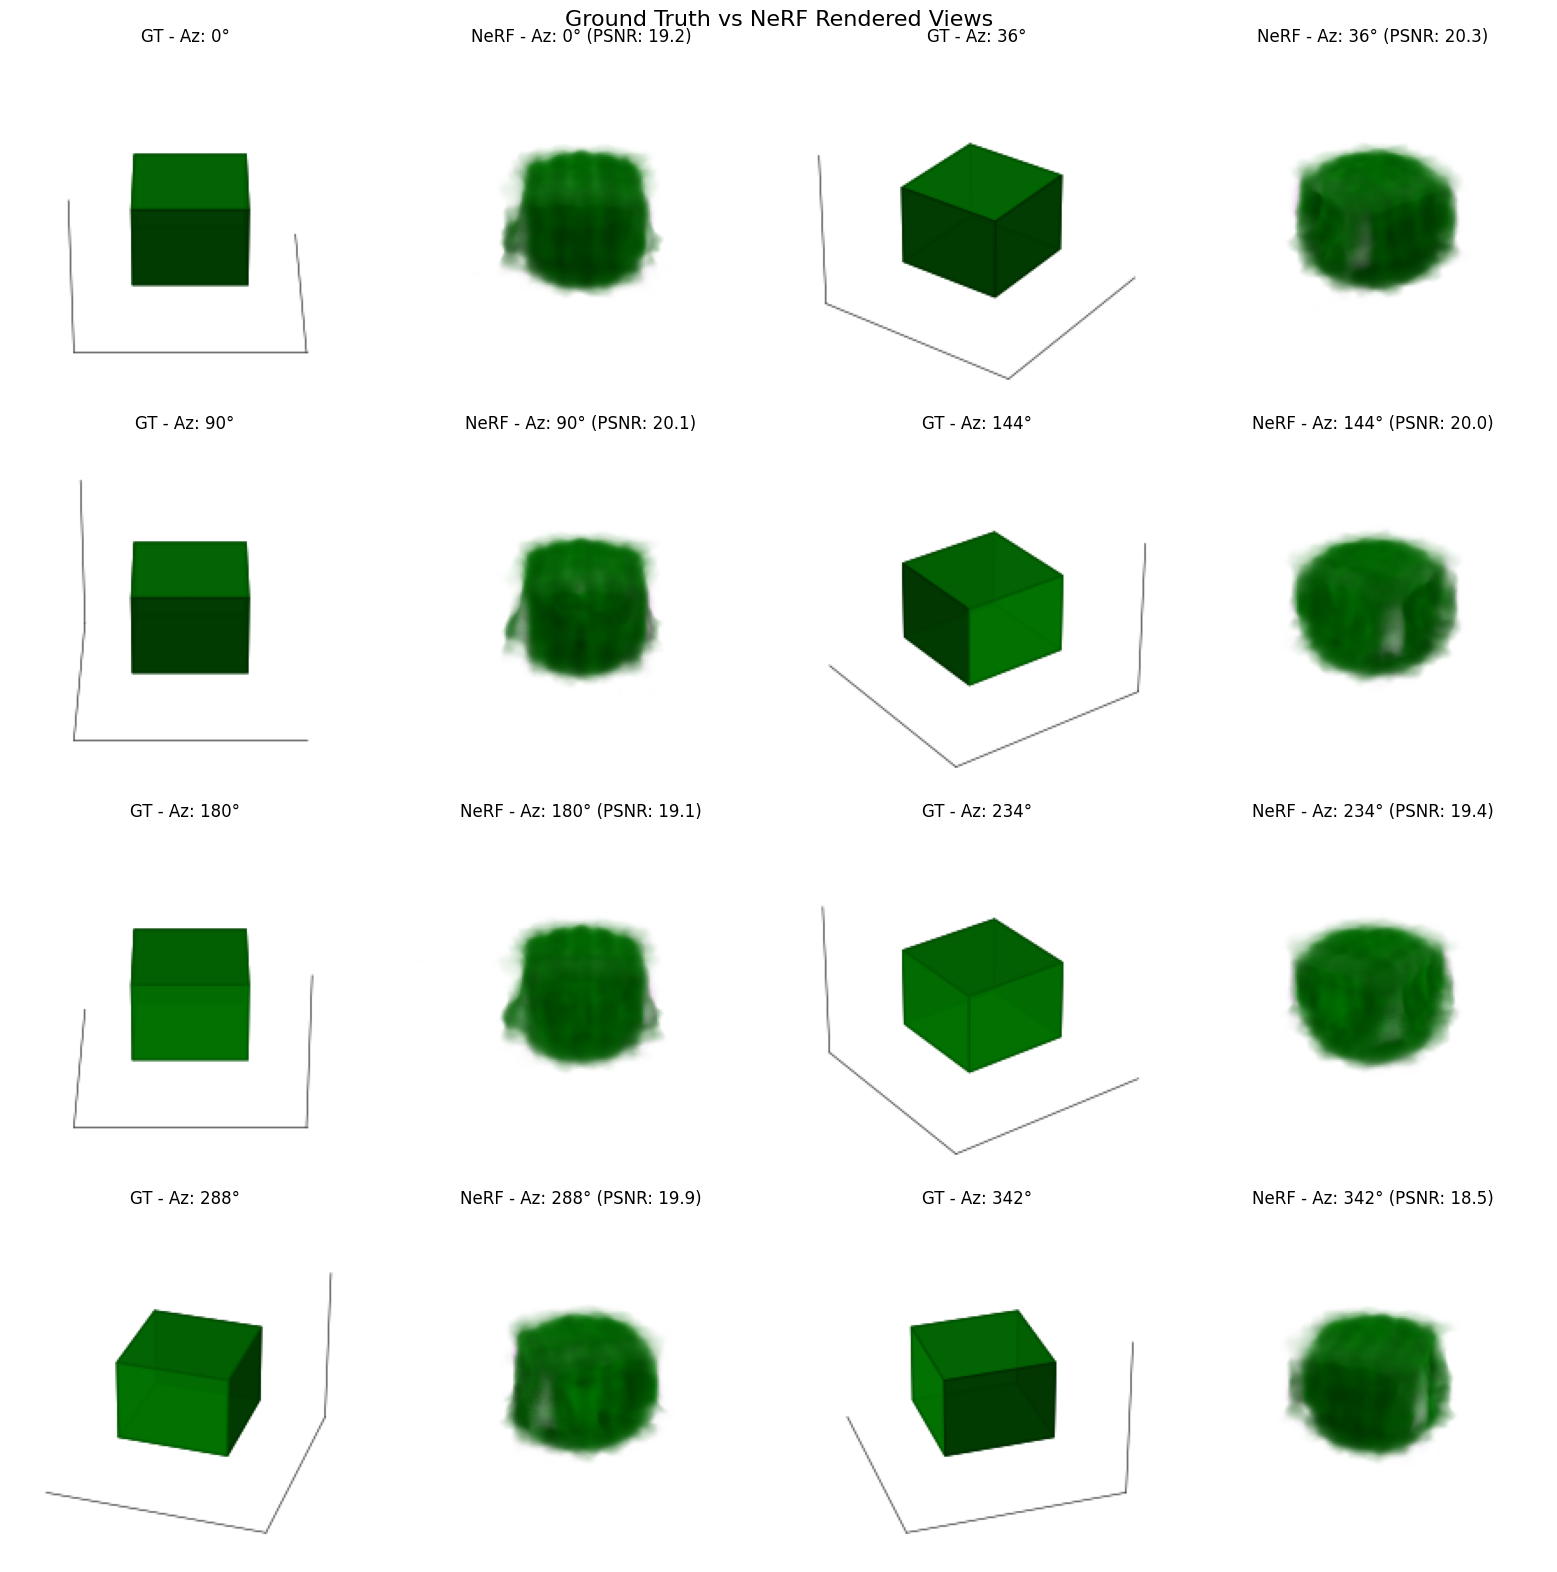

In [11]:
# Visualize ground truth vs rendered comparisons
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i in range(len(rendered_views)):
    row = i // 2
    col_gt = (i % 2) * 2      # Ground truth columns: 0, 2
    col_pred = col_gt + 1     # Predicted columns: 1, 3

    # Calculate azimuth for display
    pose = poses_torch[test_indices[i]]
    x_pos, y_pos = pose[0, 3].cpu().numpy(), pose[1, 3].cpu().numpy()
    azim = np.degrees(np.arctan2(y_pos, x_pos))
    if azim < 0:
        azim += 360

    # Ground truth
    axes[row, col_gt].imshow(gt_views[i])
    axes[row, col_gt].set_title(f"GT - Az: {azim:.0f}°")
    axes[row, col_gt].axis('off')

    # Rendered
    axes[row, col_pred].imshow(rendered_views[i])
    axes[row, col_pred].set_title(f"NeRF - Az: {azim:.0f}° (PSNR: {psnr_values[i]:.1f})")
    axes[row, col_pred].axis('off')

plt.suptitle("Ground Truth vs NeRF Rendered Views", fontsize=16)
plt.tight_layout()
plt.show()

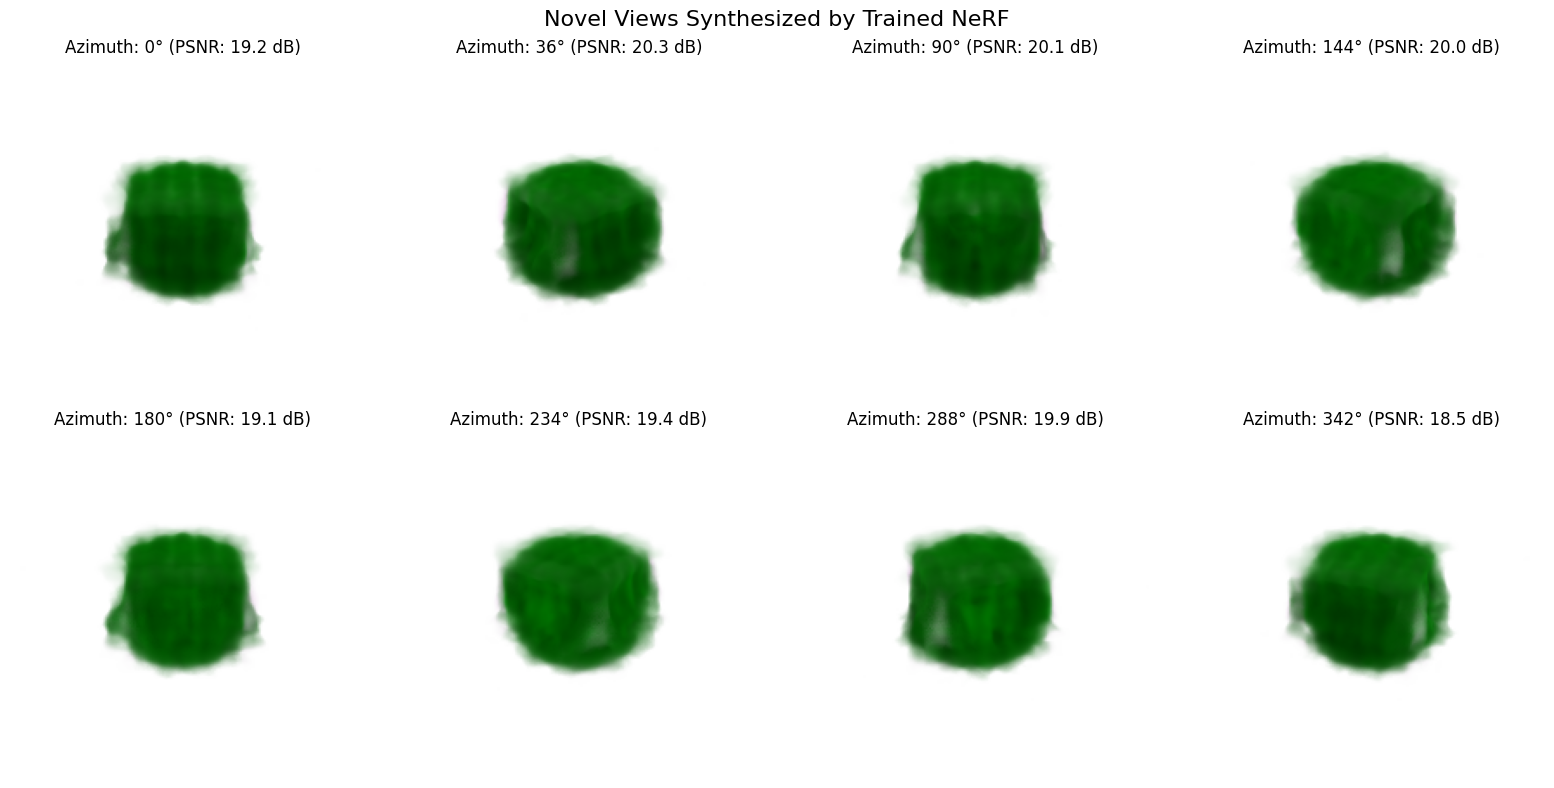


NERF TRAINING SUMMARY
Dataset size: 20 images
Training iterations: 2,000
Model parameters: 22,148
Final training loss: 0.010324
Average test PSNR: 19.55 dB
Best test PSNR: 20.32 dB
Worst test PSNR: 18.51 dB


In [12]:
# Create a compact view showing just the rendered results
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(len(rendered_views)):
    pose = poses_torch[test_indices[i]]
    x_pos, y_pos = pose[0, 3].cpu().numpy(), pose[1, 3].cpu().numpy()
    azim = np.degrees(np.arctan2(y_pos, x_pos))
    if azim < 0:
        azim += 360

    axes[i].imshow(rendered_views[i])
    axes[i].set_title(f"Azimuth: {azim:.0f}° (PSNR: {psnr_values[i]:.1f} dB)")
    axes[i].axis('off')

plt.suptitle("Novel Views Synthesized by Trained NeRF", fontsize=16)
plt.tight_layout()
plt.show()

# Performance summary
print("\n" + "="*60)
print("NERF TRAINING SUMMARY")
print("="*60)
print(f"Dataset size: {len(images_torch)} images")
print(f"Training iterations: {num_iters:,}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Final training loss: {losses[-1]:.6f}")
print(f"Average test PSNR: {avg_psnr:.2f} dB")
print(f"Best test PSNR: {max(psnr_values):.2f} dB")
print(f"Worst test PSNR: {min(psnr_values):.2f} dB")
print("="*60)

## 6. Exploring the Learned 3D Representation

Let's probe our trained NeRF to understand what it has learned about the 3D structure of our cube.

In [13]:
# Probe the learned 3D representation
def probe_nerf_3d_structure(model, encode, grid_size=64, bbox_size=2.0):
    """Sample the NeRF model on a 3D grid to visualize learned structure"""

    model.eval()

    # Create 3D grid
    coords = np.linspace(-bbox_size/2, bbox_size/2, grid_size)
    xx, yy, zz = np.meshgrid(coords, coords, coords)
    grid_points = np.stack([xx.ravel(), yy.ravel(), zz.ravel()], axis=-1)

    # Query NeRF model
    grid_points_torch = torch.from_numpy(grid_points).float().to(device)
    encoded_points = encode(grid_points_torch)

    densities = []
    colors = []

    # Process in batches
    batch_size = 8192
    with torch.no_grad():
        for i in range(0, len(encoded_points), batch_size):
            batch = encoded_points[i:i+batch_size]
            outputs = model(batch)

            density = torch.nn.functional.relu(outputs[:, 3]).cpu().numpy()
            color = torch.sigmoid(outputs[:, :3]).cpu().numpy()

            densities.append(density)
            colors.append(color)

    densities = np.concatenate(densities)
    colors = np.concatenate(colors)

    return grid_points, densities, colors

# Sample the 3D structure
print("Probing learned 3D structure...")
grid_points, densities, colors = probe_nerf_3d_structure(model, encode, grid_size=32)

# Find high-density points (the "surface" of the cube)
density_threshold = np.percentile(densities, 95)  # Top 5% of densities
surface_mask = densities > density_threshold
surface_points = grid_points[surface_mask]
surface_colors = colors[surface_mask]

print(f"Found {len(surface_points)} high-density points (>{density_threshold:.3f})")

Probing learned 3D structure...
Found 1639 high-density points (>9.219)


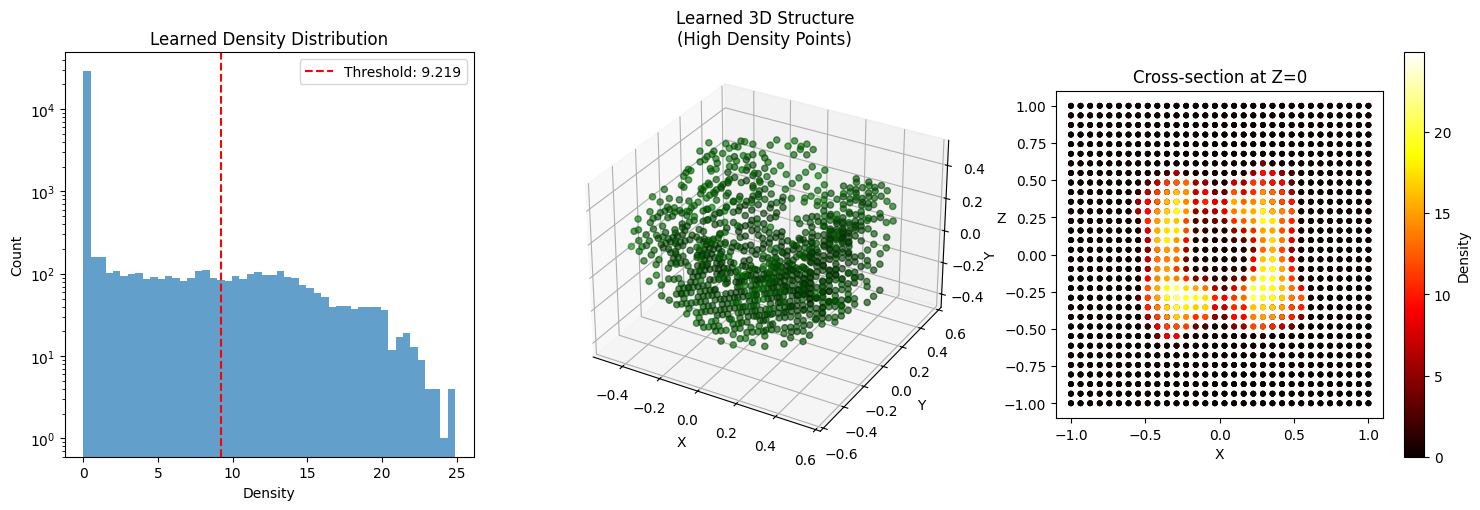


The NeRF model has learned to represent the cube structure!
High-density regions correspond to the cube's surfaces.
The model assigns low density to empty space around the cube.


In [14]:
# Visualize the learned 3D structure
fig = plt.figure(figsize=(15, 5))

# 1. Density distribution
ax1 = fig.add_subplot(131)
ax1.hist(densities, bins=50, alpha=0.7)
ax1.axvline(density_threshold, color='red', linestyle='--', label=f'Threshold: {density_threshold:.3f}')
ax1.set_xlabel('Density')
ax1.set_ylabel('Count')
ax1.set_title('Learned Density Distribution')
ax1.legend()
ax1.set_yscale('log')

# 2. 3D visualization of high-density points
ax2 = fig.add_subplot(132, projection='3d')
if len(surface_points) > 0:
    # Subsample for visualization
    subsample = np.random.choice(len(surface_points),
                               min(1000, len(surface_points)),
                               replace=False)

    points = surface_points[subsample]
    point_colors = surface_colors[subsample]

    ax2.scatter(points[:, 0], points[:, 1], points[:, 2],
               c=point_colors, s=20, alpha=0.6)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Learned 3D Structure\n(High Density Points)')

# 3. Cross-section through the cube
ax3 = fig.add_subplot(133)
# Take a slice at z=0
z_slice_idx = np.abs(grid_points[:, 2]) < 0.1  # Points near z=0
if np.any(z_slice_idx):
    slice_points = grid_points[z_slice_idx]
    slice_densities = densities[z_slice_idx]

    # Create 2D density map
    scatter = ax3.scatter(slice_points[:, 0], slice_points[:, 1],
                         c=slice_densities, cmap='hot', s=10)
    plt.colorbar(scatter, ax=ax3, label='Density')

ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_title('Cross-section at Z=0')
ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"\nThe NeRF model has learned to represent the cube structure!")
print(f"High-density regions correspond to the cube's surfaces.")
print(f"The model assigns low density to empty space around the cube.")

## Summary

🎉 **Congratulations!** You've successfully implemented and trained a Neural Radiance Field (NeRF) from scratch!

### What we accomplished:

1. **Generated synthetic training data** of a 3D cube from multiple viewpoints
2. **Built a NeRF model** using MLPs with positional encoding
3. **Implemented volume rendering** to synthesize images from 3D representations
4. **Trained the model** to learn 3D structure from 2D supervision
5. **Evaluated results** by synthesizing novel views

### Key insights:

- **NeRF learns implicit 3D representations** without explicit 3D supervision
- **Positional encoding** helps capture fine geometric details
- **Volume rendering** enables differentiable image synthesis
- **Multi-view consistency** drives the learning of accurate 3D structure

### Next steps to explore:

- Try more complex scenes with multiple objects
- Experiment with different architectures (deeper networks, skip connections)
- Add view-dependent effects for realistic materials
- Implement hierarchical sampling for better efficiency
- Apply to real photos with known camera poses

This simplified NeRF demonstrates the core concepts behind neural radiance fields. Real-world NeRF implementations include many additional optimizations and features, but the fundamental principles remain the same!